# 信用评分卡案例

加载所需包

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings(action='once')
# 设置警告只出现一次
# 不出现设置: warnings.filterwarnings('ignore')

## 确定观察时间窗口

使用用户逾期详情表data/CreditSampleWindow.csv:

- CID:用户ID
- STAGE_BEF:本阶段前的逾期阶段
- STAGE_AFT:本阶段进入的逾期阶段
    - 其中逾期阶段含义为: M0:逾期0-3天; M1:逾期3-30天; M2:逾期30-60天; M3:逾期60-90天;以此类推
- START_DATE:进入本阶段时间
- CLOSE_DATE:本阶段结束时间

本数据取的是订单审批日从2015年1月1日到2017年10月31日的所有订单号,即这些订单对应的逾期详情,最后的截止日期为2018年5月31日

### 读数据,数据描述

In [3]:
os.chdir("D:/data/python")
sample_window = pd.read_csv("CreditSampleWindow.csv")

In [4]:
sample_window.describe(include="all")

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE
count,1813157,1663660,1663660,1.663660e+06,1.663660e+06
unique,388259,10,10,NaN,NaN
top,CID0373971,,M0,NaN,NaN
freq,74,1107267,1107267,NaN,NaN
mean,NaN,NaN,NaN,2.017035e+07,1.982646e+07
std,NaN,NaN,NaN,8.220957e+03,2.611156e+06
min,NaN,NaN,NaN,2.015030e+07,0.000000e+00
25%,NaN,NaN,NaN,2.016120e+07,2.016120e+07
50%,NaN,NaN,NaN,2.017080e+07,2.017073e+07
75%,NaN,NaN,NaN,2.018010e+07,2.018010e+07


- 描述结果中发现最后一列即本阶段结束时间最小值为0,由于包含缺失值,故需要先处理缺失值再处理异常值0

查看各列缺失值占比

In [5]:
sample_window.isnull().mean()

CID           0.000000
STAGE_BEF     0.082451
STAGE_AFT     0.082451
START_DATE    0.082451
CLOSE_DATE    0.082451
dtype: float64

- isnull:判断是否是缺失值,返回布尔型的对象

### 数据清洗

#### 去重

- 对于一般模型影响不大,容易导致回归系数标准误降低,使得对应p值减小

In [6]:
sample_window.drop_duplicates(inplace=True)
sample_window.shape

(1813157, 5)

- drop_duplicates是数据框去重的函数,可以根据指定的若干列(subset=)去重

#### 缺失值处理: 

- 后四列缺失值占比都接近8%,可以验证后四列的缺失值是否在同一行,如果在同一行则可以删除缺失值所在的行

通过观察有四个缺失值的行的占比是否等于0.082451,确定四列的缺失值是否都在同一行上

In [7]:
np.mean(sample_window.isnull().sum(axis=1) == 4)

0.08245121630393838

去除缺失值所在的行

In [8]:
sample_window.dropna(inplace=True)
# dropna默认删除包含缺失值的所有行
sample_window.shape

(1663660, 5)

#### 异常值处理:

- 本阶段结束时间中:最小值为0,属于异常值,这里将不确定的时间修改为截至日期即2018年5月31日

In [9]:
sample_window.CLOSE_DATE.replace({0.:20180531.},inplace=True)

- replace:替换数据框中的指定值,输入字典,键是被替换值,值是替换值

#### 生成衍生变量:

- 从数据中的进入本阶段时间和本阶段结束时间(4,5列)抽取对应的月份信息
- 从本阶段进入的逾期阶段(3列)中抽取逾期指标

In [10]:
sample_window[["START_MONTH","CLOSE_MONTH"]] = sample_window[
    ["START_DATE","CLOSE_DATE"]].apply(lambda x: x//100).astype(int)
sample_window["AFT_FLAG"] = sample_window.STAGE_AFT.apply(lambda x: int(x[1:]))

- apply:对数据框的每列执行指定的函数
- astype:转换数据框的对象类型

In [11]:
sample_window.head()

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
0,CID0128273,,M0,20170701.0,20170703.0,201707,201707,0
1,CID0214787,,M0,20180201.0,20180204.0,201802,201802,0
2,CID0287932,M4,M5,20180501.0,20180531.0,201805,201805,5
3,CID0351850,,M0,20161002.0,20161005.0,201610,201610,0
4,CID0217310,,M0,20150601.0,20150602.0,201506,201506,0


In [12]:
sample_window.describe()

,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
count,1.663660e+06,1.663660e+06,1.663660e+06,1.663660e+06,1.663660e+06
mean,2.017035e+07,2.017052e+07,2.017035e+05,2.017051e+05,7.400304e-01
std,8.220957e+03,8.251640e+03,8.221037e+01,8.251215e+01,1.627142e+00
min,2.015030e+07,2.015030e+07,2.015030e+05,2.015030e+05,0.000000e+00
25%,2.016120e+07,2.016121e+07,2.016120e+05,2.016120e+05,0.000000e+00
50%,2.017080e+07,2.017080e+07,2.017080e+05,2.017080e+05,0.000000e+00
75%,2.018010e+07,2.018013e+07,2.018010e+05,2.018010e+05,1.000000e+00
max,2.018053e+07,2.018053e+07,2.018050e+05,2.018050e+05,9.000000e+00


### 构建矩阵

- 这里的**矩阵**表示: 相继时间内逾期状态的变化情况,相继时间表示从一个月到下一个月
- 每一行表示开始月份时的逾期状态,每一列表示结束月份时的逾期状态
- 开始月份和结束月份是相继的,即间隔一个月

#### 构建逻辑:

1. 每一行数据对应一个本阶段的逾期状态,对应两个月份时间:进入本阶段时间和本阶段结束时间
    - 可以将这两个时间都理解为逾期状态对应的时间,即逾期时间
    - 生成**逾期状态数据框**,每行对应三列:id,逾期状态,逾期时间(包含进入本阶段时间和本阶段结束时间)
2. 将**逾期状态数据框**内转置,生成**时间数据框**:行是id,列是逾期时间
    - 转置前事先对数据排序,去重,保留同ID,同时间下逾期状态的最大值
3. 使用**时间数据框**:由于列是已经排序的两列,取前后相继的两列,即相继的两个月,统计逾期状态变化的频数,得到所有相继两列状态变化的频数
    - 根据统计的频数,构建**矩阵**,行表示相继时间中开始时间对应的逾期状态,列表示结束时间对应的逾期状态
4. 使用得到的矩阵,生成新列:
    - 每个状态所有可能的变化,即行和
    - 每个状态所有不好的变化,即表示状态的数字变大
    - 每个状态不好的变化的占比,即不好的变化除以所有可能的变化

#### 生成逾期状态数据框:

In [13]:
overdue = sample_window.iloc[:,[0,5,7]].rename(
        columns={"START_MONTH":"CLOSE_MONTH"}).append(
                sample_window.iloc[:,[0,6,7]],ignore_index=True,sort=False)

- rename:改变轴标签, 给index或columns赋值函数或者字典,函数的输入输出必须是1对1的
- append:用于行合并, 对应列名合并,列名不同填充NaN,ignore_index表示忽略原始索引,sort表示合并时是否排序

In [14]:
overdue.head()

,CID,CLOSE_MONTH,AFT_FLAG
0,CID0128273,201707,0
1,CID0214787,201802,0
2,CID0287932,201805,5
3,CID0351850,201610,0
4,CID0217310,201506,0


#### 生成时间数据框:

In [15]:
overdue = overdue.sort_values(by=["CID","CLOSE_MONTH","AFT_FLAG"
                        ]).drop_duplicates(["CID","CLOSE_MONTH"],keep="last")

排序和去重:

- sort_values:依据值排序,缺失值默认在末尾.依据指定列进行排序,设置by=一列或多列(列表)列名即可
- drop_duplicates:根据若干列去重, 设置subset指定列,keep表示要保留的数据,可选"first","last",False(表示去掉所有重复的行)

In [16]:
overdue = overdue.set_index(["CID","CLOSE_MONTH"]).unstack(1)

- set_index:给出若干列,将列作为行索引(每行可以有多个索引)
- unstack:level=-1, fill_value=None, 第一个参数表示以哪列索引作为列, 默认最后一列, 相当于以选定的索引列作为列名, 其他作为行名

In [17]:
overdue.head()

AFT_FLAG                                                          \
CLOSE_MONTH   201503 201504 201505 201506 201507 201508 201509 201510 201511   
CID                                                                            
CID0000000       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000003       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000004       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000006       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                    ...                                                   \
CLOSE_MONTH 201512  ... 201708 201709 201710 201711 201712 201801 201802   
CID                 ...                                                    
CID0000000     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001     0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000003     NaN  ...    NaN    NaN    NaN    NaN    0.0    0.0    0.0   
CID0000004     0.0  ...    0.0    NaN    0.0    NaN    1.0    0.0    0.0   
CID0000006     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                  
CLOSE_MONTH 201803 201804 201805  
CID                               
CID0000000     NaN    NaN    NaN  
CID0000001     NaN    NaN    NaN  
CID0000003     NaN    NaN    NaN  
CID0000004     0.0    0.0    NaN  
CID0000006     NaN    NaN    0.0  

[5 rows x 39 columns]

发现列索引是多重索引,即有两个索引,进一步查看列索引如下

In [18]:
overdue.columns

MultiIndex(levels=[['AFT_FLAG'], [201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805]],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]],
           names=[None, 'CLOSE_MONTH'])

删除其中的第一个索引,名字为None,等级为"AFT_FLAG"的索引

In [19]:
overdue.columns = overdue.columns.droplevel()

- droplevel:删除多重索引中指定的某些索引, 例如行索引有两列, 删除指定列,参数axis默认为0表示行

In [20]:
overdue.head()

CLOSE_MONTH,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,...,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805
CID,,,,,,,,,,,,,,,,,,,,,
CID0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CID0000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CID0000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
CID0000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,NaN
CID0000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


#### 生成矩阵

初始化一个10行10列的零矩阵

In [21]:
trans_mat = pd.DataFrame(data=0,columns=range(0,10),
                         index=range(0,10))

初始化计数器

In [22]:
counter = Counter()

- Counter:生成空计数器,使用字典记录对应元素(键)的频数(值)

In [23]:
for i,j in zip(overdue.columns,overdue.columns[1:]):
    # 对相继的两列依此循环,zip将相继月份生成元祖,
    select = (overdue[i].notnull()) & (overdue[j].notnull())
    # 对于相继两列,返回行数据不为空对应的布尔对象
    # notnull判断对象是否不是缺失值,返回相同尺寸的布尔对象
    counter += Counter([tuple(x) 
                        for x in overdue.loc[select,[i,j]].values])
    # 抽取非空的每一行的数值,即相继状态,转化成元祖,加到计数器里
# 循环结束生成所有相继状态对应的频数

查看生成的频数字典对应的元祖

In [24]:
counter.items()

dict_items([((1.0, 0.0), 59218), ((0.0, 0.0), 218269), ((1.0, 1.0), 169811), ((0.0, 1.0), 78639), ((2.0, 2.0), 3775), ((2.0, 3.0), 17287), ((2.0, 1.0), 4061), ((1.0, 3.0), 9020), ((1.0, 2.0), 20351), ((3.0, 3.0), 1686), ((0.0, 2.0), 3232), ((3.0, 4.0), 22226), ((3.0, 0.0), 184), ((4.0, 5.0), 13634), ((2.0, 0.0), 556), ((5.0, 6.0), 14936), ((5.0, 5.0), 211), ((4.0, 4.0), 233), ((3.0, 2.0), 586), ((6.0, 6.0), 179), ((6.0, 7.0), 17223), ((3.0, 1.0), 1233), ((4.0, 1.0), 20), ((7.0, 8.0), 14262), ((8.0, 9.0), 12527), ((4.0, 2.0), 5), ((7.0, 7.0), 1292), ((2.0, 4.0), 7), ((9.0, 9.0), 247), ((8.0, 8.0), 98), ((4.0, 0.0), 1), ((3.0, 5.0), 446), ((5.0, 7.0), 911), ((6.0, 8.0), 9), ((4.0, 6.0), 2803), ((1.0, 6.0), 8), ((7.0, 9.0), 4), ((9.0, 7.0), 12), ((9.0, 8.0), 22), ((9.0, 5.0), 4), ((9.0, 6.0), 8), ((9.0, 3.0), 4), ((6.0, 3.0), 2), ((9.0, 1.0), 10), ((5.0, 2.0), 2), ((1.0, 5.0), 16), ((8.0, 7.0), 4), ((9.0, 2.0), 2), ((7.0, 6.0), 8), ((7.0, 1.0), 8), ((7.0, 4.0), 8), ((8.0, 0.0), 2), ((5.0,

将生成的频数对应到之前生成的零矩阵中

In [25]:
for key in counter.keys():
    # 对于所有的键循环
    trans_mat.loc[key[0],key[1]] = counter[key]
    # 每个键的元祖中,两个值分别对应零矩阵行列的值,对应位置赋值键对应的值

In [26]:
trans_mat

,0,1,2,3,4,5,6,7,8,9
0,218269,78639,3232,0,0,0,0,0,2,2
1,59218,169811,20351,9020,0,16,8,8,2,6
2,556,4061,3775,17287,7,0,0,0,0,0
3,184,1233,586,1686,22226,446,0,0,0,2
4,1,20,5,0,233,13634,2803,8,0,0
5,0,2,2,0,0,211,14936,911,0,0
6,0,0,0,2,0,0,179,17223,9,8
7,0,8,0,0,8,0,8,1292,14262,4
8,2,2,0,0,0,0,2,4,98,12527
9,0,10,2,4,0,4,8,12,22,247


生成新列

- 每个状态所有可能的变化,即行和

In [27]:
trans_mat["all_count"] = trans_mat.sum(axis=1)

- 每个状态所有不好的变化,即表示状态的数字变大

In [28]:
bad_count = []
for i in range(10):
    # 循环每一行
    bad_count.append(trans_mat.iloc[i,(i+1):10].sum())
    # 对第i行i+1列之后的数求和,即状态i数字变大,状态变坏
trans_mat["bad_count"] = bad_count

- 每个状态不好的变化的占比,即不好的变化除以所有可能的变化

In [29]:
trans_mat["bad_ratio"] = trans_mat.bad_count/trans_mat.all_count

### 根据生成矩阵确定观察时间窗口

最终的矩阵:

In [30]:
trans_mat

,0,1,2,3,4,5,6,7,8,9,all_count,bad_count,bad_ratio
0,218269,78639,3232,0,0,0,0,0,2,2,300144,81875,0.272786
1,59218,169811,20351,9020,0,16,8,8,2,6,258440,29411,0.113802
2,556,4061,3775,17287,7,0,0,0,0,0,25686,17294,0.673285
3,184,1233,586,1686,22226,446,0,0,0,2,26363,22674,0.860069
4,1,20,5,0,233,13634,2803,8,0,0,16704,16445,0.984495
5,0,2,2,0,0,211,14936,911,0,0,16062,15847,0.986614
6,0,0,0,2,0,0,179,17223,9,8,17421,17240,0.989610
7,0,8,0,0,8,0,8,1292,14262,4,15582,14266,0.915544
8,2,2,0,0,0,0,2,4,98,12527,12635,12527,0.991452
9,0,10,2,4,0,4,8,12,22,247,309,0,0.000000


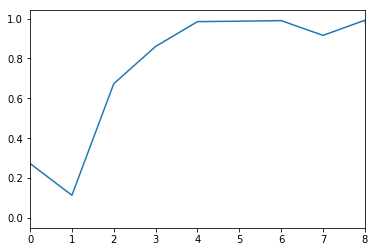

In [31]:
plt.plot(trans_mat.index,trans_mat.bad_ratio)
plt.xticks(np.arange(0,9))
plt.xlim(0,8)
plt.show()

- 可见M1是一个明显的最低点和拐点,到M2阶段以后坏客户的比例迅速增加,因此这里选定的观察时间窗口为M2,即30-60天,我们就可以定义逾期大于30天的客户为坏客户
- 可以根据业务需求进一步调整观察时间窗口

## 确定表现时间窗口

使用用户订单时间表data/CreditFirstUse.csv:

- CID:用户ID
- FST_USE_DT:用户订单时间

### 读数据,数据描述

In [32]:
perf_window = pd.read_csv("CreditFirstUse.csv")

In [33]:
print(perf_window.shape)
perf_window.describe(include="all")

(388259, 2)


,CID,FST_USE_DT
count,388259,3.882590e+05
unique,388259,NaN
top,CID0203590,NaN
freq,1,NaN
mean,NaN,2.016187e+07
std,NaN,7.896603e+03
min,NaN,2.015010e+07
25%,NaN,2.015121e+07
50%,NaN,2.016101e+07
75%,NaN,2.017051e+07


- 可见没有缺失值,没有重复订单号
- 用户订单时间从2015年1月1日到2017年10月31日,初步判断没有异常值

### 数据清洗

设置行索引为CID列,方便加行的时候直接匹配

In [34]:
perf_window.set_index("CID",inplace=True)

从用户订单时间中抽取月份生成新列:首次使用月

In [35]:
perf_window["FST_USE_MON"] = (perf_window.FST_USE_DT//100).astype(float)

In [36]:
perf_window.head()

,FST_USE_DT,FST_USE_MON
CID,,
CID0092102,20161116,201611.0
CID0111878,20161118,201611.0
CID0264977,20161120,201611.0
CID0059996,20160907,201609.0
CID0057096,20160910,201609.0


使用前面生成的**时间数据框**:

- 由于选取观察时间窗口为M2,对于每个ID:
    - 取逾期状态大于等于2的首个月作为逾期月
    - 逾期月表示客户开始转向坏客户
- 使用逾期月生成新列

In [37]:
overdue_m2 = overdue >= 2
# 判断逾期状态是否大于等于2,返回对应尺寸的布尔数据
overdue_m2 = overdue_m2[overdue_m2.sum(axis=1)>0]
# 筛选行和大于0的数据,即寻找那些曾经转为坏客户的ID行

In [38]:
overdue_month = overdue_m2.apply(lambda x: 
    overdue_m2.columns[x][0],axis=1)
# 每行取转为坏客户的第一个月(逾期状态大于等于2)作为逾期月
perf_window["OVERDUE_MON"] = overdue_month
# 逾期月生成新列

In [39]:
perf_window[perf_window.OVERDUE_MON.notnull()].head()
# 查看非空数据

,FST_USE_DT,FST_USE_MON,OVERDUE_MON
CID,,,
CID0082006,20160906,201609.0,201705.0
CID0383647,20160906,201609.0,201708.0
CID0006192,20161022,201610.0,201707.0
CID0348120,20161122,201611.0,201712.0
CID0155834,20161123,201611.0,201707.0


计算首次使用月和逾期月的月份差,生成新列

In [40]:
def diffmon(x,y):
    return((x//100 - y//100)*12 + x%100 - y%100)
# 定义函数,计算两个月份数据的月份差

In [41]:
perf_window["DIFF_MON"] = diffmon(perf_window.OVERDUE_MON,
           perf_window.FST_USE_MON)
# 计算月份差,生成新列

In [42]:
perf_window[perf_window.OVERDUE_MON.notnull()].head()
# 查看非空数据

,FST_USE_DT,FST_USE_MON,OVERDUE_MON,DIFF_MON
CID,,,,
CID0082006,20160906,201609.0,201705.0,8.0
CID0383647,20160906,201609.0,201708.0,11.0
CID0006192,20161022,201610.0,201707.0,9.0
CID0348120,20161122,201611.0,201712.0,13.0
CID0155834,20161123,201611.0,201707.0,8.0


统计月份差异的频数,并且排序

- 发现有的时间差是负的,把排序后前面负的时间差去掉

In [43]:
mon_freq = perf_window.DIFF_MON.value_counts(normalize=True).sort_index()[1:]
# 统计月份差列的频率

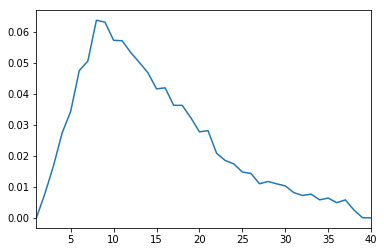

In [44]:
mon_freq.plot()
# 得到的频率生成图形

- 可见月份差是偏右偏的分布

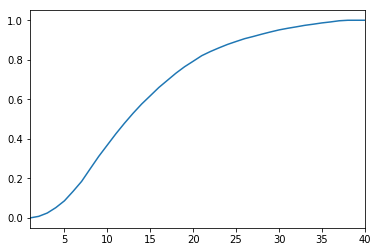

In [45]:
mon_freq.cumsum().plot()

- 可见当表现时间窗口为20的时候,累积概率接近80%,即覆盖80%的客户
- 如果认为覆盖80%的客户得到的模型相对稳定,则定义表现时间窗口为20个月,即首20期以后

### 定义y的总结

- 通过之前的数据筛选和汇总,我们定义观察时间窗口为M2(30-60天),表现时间窗口为20
- 即对于所有客户来说,我们认为在订单生成20个月内
    - 有M2以上的逾期,即逾期天数>=31天,为坏客户
    - 有M1以下的逾期,即逾期天数<=3天,为好客户
    - 中间状态的样本认为是不确定的不进入模型

## 评分卡制作

该数据是信贷数据,来自kaggle2011年的竞赛数据:[Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/overview),评判指标是AUC

- SeriousDlqin2yrs:出现90天或更长时间的逾期行为(即定义好坏客户)
- RevolvingUtilizationOfUnsecuredLines:贷款以及信用卡可用额度与总额度比例
- age:借款人借款年龄
- NumberOfTime30-59DaysPastDueNotWorse:过去两年内出现35-59天逾期但是没有发展的更坏的次数
- DebtRatio:每月偿还债务,赡养费,生活费用除以月总收入
- MonthlyIncome:月收入
- NumberOfOpenCreditLinesAndLoans:开放式贷款和信贷数量
- NumberOfTimes90DaysLate:借款者有90天或更高逾期的次数
- NumberRealEstateLoansOrLines:抵押贷款和房地产贷款数量,包括房屋净值信贷额度
- NumberOfTime60-89DaysPastDueNotWorse:过去两年内出现60-89天逾期但是没有发展的更坏的次数
- NumberOfDependents:家庭中不包括自身的家属人数(配偶,子女等)

### 读数据,数据描述

In [46]:
os.chdir("D:/data/python")
train_data = pd.read_csv("cs-training.csv",index_col=0)
# index_col指明y的索引是第几列

In [47]:
print(train_data.shape)
train_data.describe(include="all",percentiles=[0.5]).T.round(2)

(150000, 11)


,count,mean,std,min,50%,max
SeriousDlqin2yrs,150000.0,0.07,0.25,0.0,0.00,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.05,249.76,0.0,0.15,50708.0
age,150000.0,52.30,14.77,0.0,52.00,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.42,4.19,0.0,0.00,98.0
DebtRatio,150000.0,353.01,2037.82,0.0,0.37,329664.0
MonthlyIncome,120269.0,6670.22,14384.67,0.0,5400.00,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.45,5.15,0.0,8.00,58.0
NumberOfTimes90DaysLate,150000.0,0.27,4.17,0.0,0.00,98.0
NumberRealEstateLoansOrLines,150000.0,1.02,1.13,0.0,1.00,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.24,4.16,0.0,0.00,98.0


修改列名:由于一些算法中,列名中的某些符号会带来问题甚至报错,例如这里的"-",会在回归公式中被认为是减号,所以换成"_"

In [48]:
train_data.columns = train_data.columns.map(lambda x: x.replace("-","_"))

查看各列缺失值占比

In [49]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30_59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60_89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

#### 去重

- 对于一般模型影响不大,容易导致回归系数标准误降低,使得对应p值减小

In [50]:
train_data.drop_duplicates(inplace=True)
train_data.shape

(149391, 11)

- 可见数据中存在重复行

### 缺失值处理

缺失值处理方法的选择,主要依据是业务逻辑和缺失值占比,在对预测结果的影响尽可能小的情况下,对缺失值进行处理以满足算法需求,所以要理解每个缺失值处理方法带来的影响,下面的缺失值处理方法没有特殊说明均是对特征(列)的处理:

1. 占比较多:如80%以上:删除缺失值所在的列
    - 如果某些行缺失值占比较多,或者缺失值所在字段是苛刻的必须有值的,删除行
2. 占比一般:如30%-80%:将缺失值作为单独的一个分类
    - 如果特征是连续的,则其他已有值分箱
    - 如果特征是分类的,考虑其他分类是否需要重分箱
3. 占比少:10%-30%:多重插补:认为若干特征之间有相关性,则可以相互预测缺失值
    - 需满足的假设:MAR:Missing At Random:数据缺失的概率仅和已观测的数据相关,即缺失的概率与未知的数据无关,即与变量的具体数值无关
    - 迭代(循环)次数可能的话超过40,选择所有的变量甚至额外的辅助变量
    - 详细的计算过程参考:[Multiple Imputation by Chained Equations: What is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)
4. 占比较少:10%以下:单一值替换,如中位数,众数
5. 在决策树中可以将缺失值处理融合到算法里:按比重分配

这里的占比并不是固定的,例如缺失值占比只有5%,仍可以用第二种方法,主要依据业务逻辑和算法需求

#### 查看缺失值分布情况

In [51]:
import missingno as msno
# 处理缺失值的包,需要安装

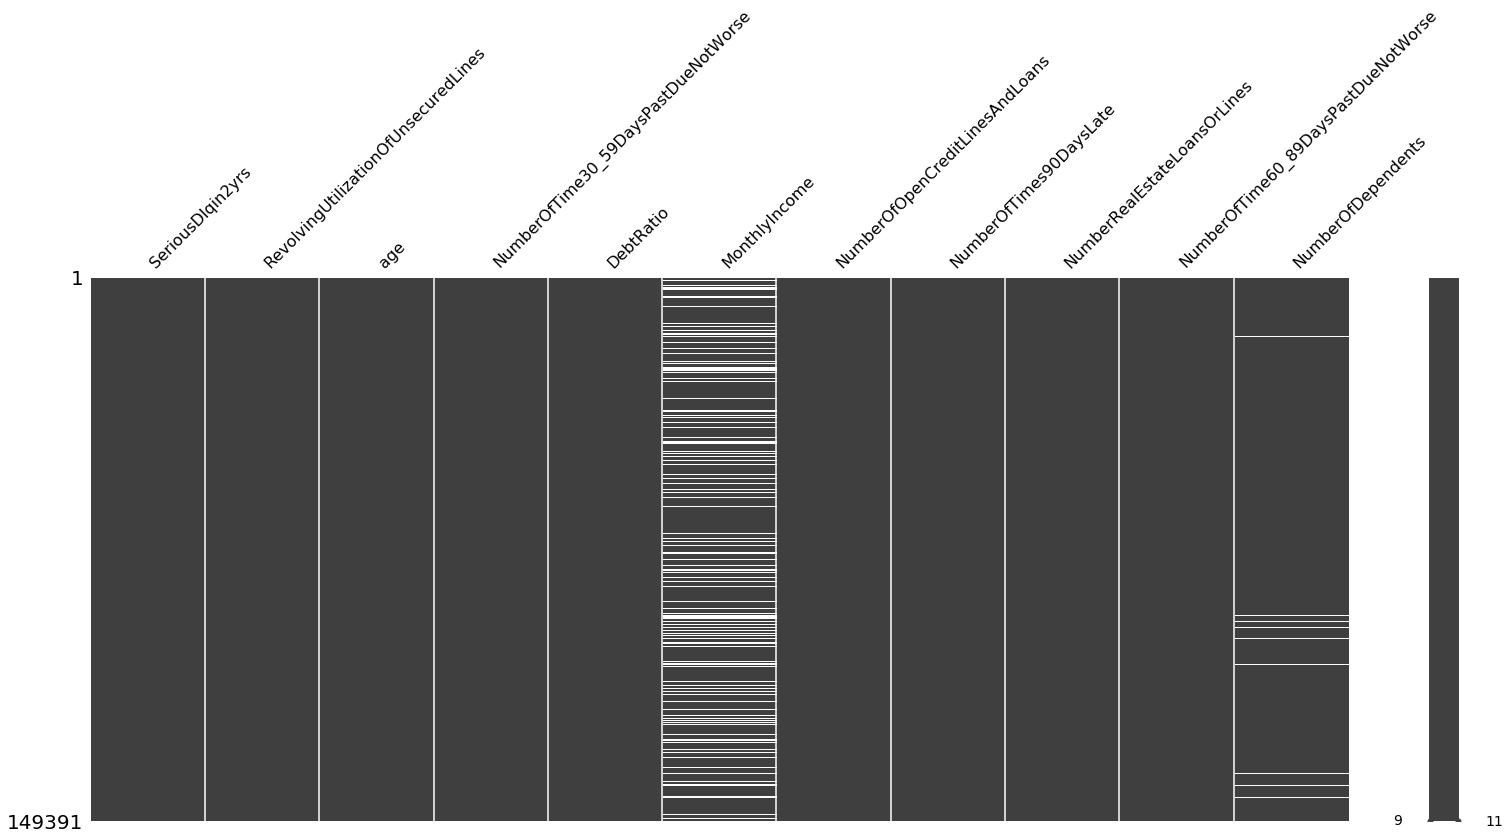

In [52]:
msno.matrix(train_data)
plt.show()

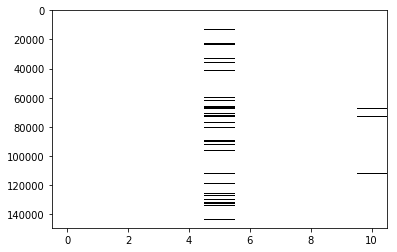

In [53]:
plt.imshow(~train_data.isna(),aspect="auto")
plt.gray()

本数据的缺失值处理逻辑:

- 对于信用评分卡来说,由于所有变量都需要分箱,故这里缺失值作为单独的箱子即可
- 对于最后一列NumberOfDependents,缺失值占比只有2.56%,作为单独的箱子信息不够,故做单一值填补,这列表示家庭人口数,有右偏的倾向,且属于计数的数据,故使用中位数填补
- 这里没必要进行多重插补,下面的多重插补只是为了让读者熟悉此操作

#### 尝试多重插补

In [54]:
from statsmodels.imputation import mice
# 加载所需包

In [55]:
imdata = train_data.copy()
# 拷贝数据
imp = mice.MICEData(imdata)
# 指定数据
imp.update_all(20)
# 指定MICE的迭代次数

C:\Programs\Anaconda3\lib\site-packages\statsmodels\imputation\mice.py:1081: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ix = dxi[[jj, ir]]
C:\Programs\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
imdata_new = imp.data
imdata_new.describe(include="all").T.round(2)

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,149391.0,0.07,0.25,0.0,0.00,0.00,0.00,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.07,250.26,0.0,0.03,0.15,0.56,50708.0
age,149391.0,52.31,14.73,0.0,41.00,52.00,63.00,109.0
NumberOfTime30_59DaysPastDueNotWorse,149391.0,0.39,3.85,0.0,0.00,0.00,0.00,98.0
DebtRatio,149391.0,354.44,2041.84,0.0,0.18,0.37,0.88,329664.0
MonthlyIncome,149391.0,6186.86,13162.38,0.0,3000.00,5000.00,7750.00,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.48,5.14,0.0,5.00,8.00,11.00,58.0
NumberOfTimes90DaysLate,149391.0,0.24,3.83,0.0,0.00,0.00,0.00,98.0
NumberRealEstateLoansOrLines,149391.0,1.02,1.13,0.0,0.00,1.00,2.00,54.0
NumberOfTime60_89DaysPastDueNotWorse,149391.0,0.21,3.81,0.0,0.00,0.00,0.00,98.0


可以看到所有的缺失值已经填补了

#### 单一值替换

将最后一列NumberOfDependents的缺失值替换成中位数 

In [57]:
NOD_median =  train_data["NumberOfDependents"].median()
train_data["NumberOfDependents"].fillna(NOD_median,inplace=True)
# fillna填补缺失值的函数,这里用中位数填补

### 异常值处理

异常值常见的处理方法:

1. 删除所在的行
2. 替换成缺失值,与缺失值一起处理
3. 盖帽法处理

结合业务逻辑和算法需求判断是否需要处理异常值以及如何处理,一般情况下盖帽法即可,即将极端异常的值改成不那么异常的极值,当然一些算法例如决策树中连续变量的异常值也可以不做处理

#### 定义盖帽法函数

In [58]:
def block(x,lower=True,upper=True):
# x是输入的Series对象,lower表示是否替换1%分位数,upper表示是否替换99%分位数
    ql = x.quantile(.01)
    qu = x.quantile(.99)
    if lower:
        out = x.mask(x<ql,ql)
    if upper:
        out = x.mask(x>qu,qu)
    return(out)

- 互换y中的0,1

In [59]:
train_data["SeriousDlqin2yrs"] = -(train_data.SeriousDlqin2yrs-1)

#### 汇总清洗过程,生成函数

In [60]:
def datacleaning(testdata,include_y=False):
    testdata.columns = testdata.columns.map(lambda x: x.replace("-","_"))
    testdata["NumberOfDependents"].fillna(NOD_median,inplace=True)
    if include_y:
        testdata["SeriousDlqin2yrs"] = -(testdata["SeriousDlqin2yrs"]-1)
    return(testdata)

### 对每个x生成分箱对象

对每个x生成一个对象;记录IV值;生成WOE图

- 运行自定义函数所在的文件

In [61]:
%run smob.py

<Figure size 432x288 with 0 Axes>

- 定义y的名字
- 初始化IV值对象

In [62]:
y = "SeriousDlqin2yrs"
iv_all = pd.Series()

#### RevolvingUtilizationOfUnsecuredLines

C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


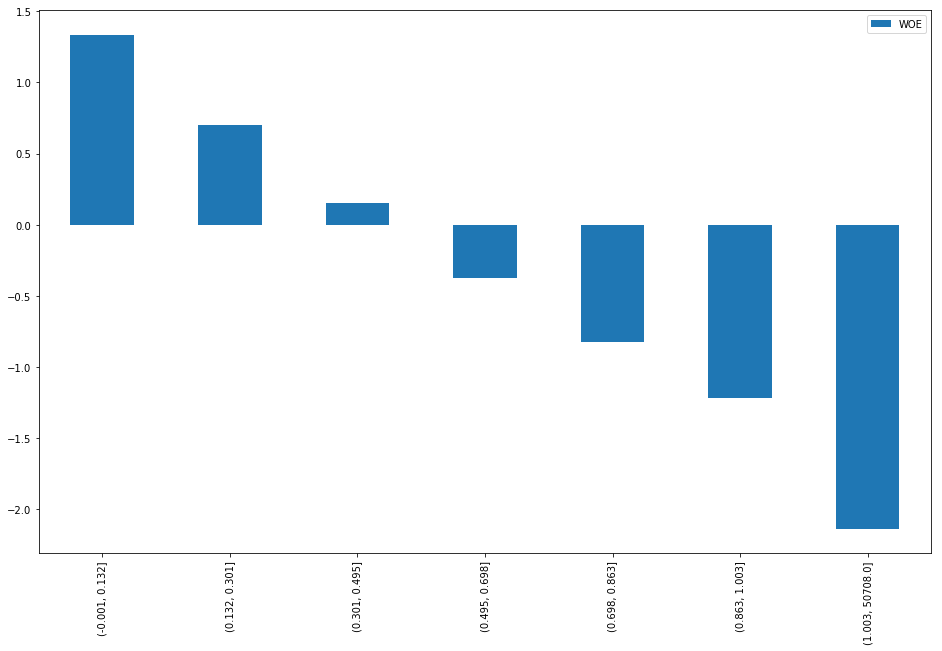

In [63]:
RUO = smbin(train_data,y,"RevolvingUtilizationOfUnsecuredLines")

- 查看IVtable

In [64]:
RUO.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.132]",70734,69424,1310,0.473482,0.498084,0.130882,1.3365,0.4908
1,"(0.132, 0.301]",21938,21185,753,0.146850,0.151992,0.075232,0.7032,0.0540
2,"(0.301, 0.495]",15380,14486,894,0.102951,0.103930,0.089320,0.1515,0.0022
3,"(0.495, 0.698]",11599,10499,1100,0.077642,0.075325,0.109901,-0.3778,0.0131
4,"(0.698, 0.863]",7985,6860,1125,0.053450,0.049217,0.112399,-0.8258,0.0522
5,"(0.863, 1.003]",18592,14962,3630,0.124452,0.107345,0.362674,-1.2175,0.3109
6,"(1.003, 50708.0]",3163,1966,1197,0.021173,0.014105,0.119592,-2.1376,0.2255
7,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,1.1487


- 查看树结构

In [65]:
print(RUO.Tree_structure)

The cart tree structure has 13 nodes, tree structure: 
node = 0 test node: go to node 1 if RevolvingUtilizationOfUnsecuredLines <= 0.7 else to node 2.
	node = 1 test node: go to node 5 if RevolvingUtilizationOfUnsecuredLines <= 0.3 else to node 6.
	node = 2 test node: go to node 3 if RevolvingUtilizationOfUnsecuredLines <= 1.0 else to node 4.
		node = 3 test node: go to node 7 if RevolvingUtilizationOfUnsecuredLines <= 0.86 else to node 8.
		node = 4 leaf node.
		node = 5 test node: go to node 11 if RevolvingUtilizationOfUnsecuredLines <= 0.13 else to node 12.
		node = 6 test node: go to node 9 if RevolvingUtilizationOfUnsecuredLines <= 0.49 else to node 10.
			node = 7 leaf node.
			node = 8 leaf node.
			node = 9 leaf node.
			node = 10 leaf node.
			node = 11 leaf node.
			node = 12 leaf node.



- 保存IV值

In [66]:
iv_all = iv_all.append(pd.Series({"RevolvingUtilizationOfUnsecuredLines":RUO.IV}))

#### age

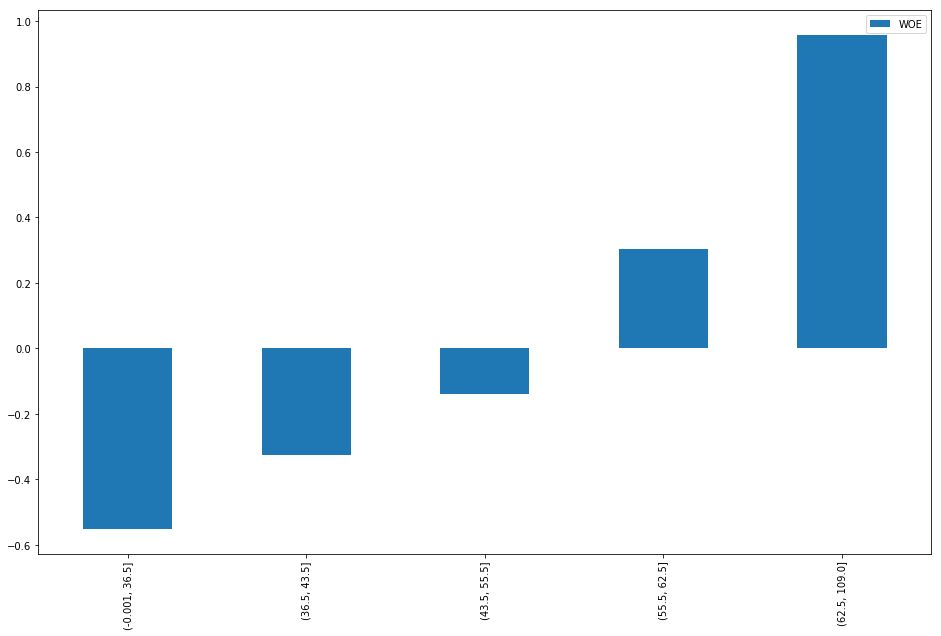

In [67]:
age = smbin(train_data,y,"age")

- 查看IVtable

In [68]:
age.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 36.5]",23628,21011,2617,0.158162,0.150744,0.261465,-0.5507,0.0610
1,"(36.5, 43.5]",20609,18746,1863,0.137953,0.134494,0.186132,-0.3249,0.0168
2,"(43.5, 55.5]",43428,40119,3309,0.290700,0.287835,0.330602,-0.1385,0.0059
3,"(55.5, 62.5]",23972,22764,1208,0.160465,0.163321,0.120691,0.3025,0.0129
4,"(62.5, 109.0]",37754,36742,1012,0.252719,0.263606,0.101109,0.9583,0.1557
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.2523


- 保存IV值

In [69]:
iv_all = iv_all.append(pd.Series({"age":age.IV}))

#### NumberOfTime30_59DaysPastDueNotWorse

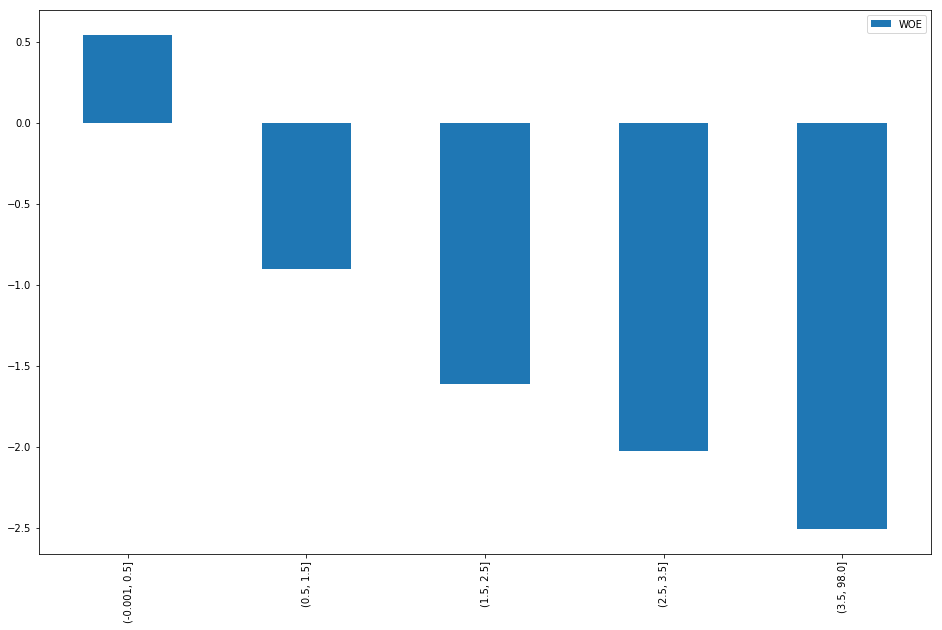

In [70]:
NO3059 = smbin(train_data,y,"NumberOfTime30_59DaysPastDueNotWorse")

In [71]:
NO3059.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",125453,120418,5035,0.839763,0.863942,0.503047,0.5408,0.1952
1,"(0.5, 1.5]",16033,13624,2409,0.107322,0.097746,0.240683,-0.9011,0.1288
2,"(1.5, 2.5]",4598,3379,1219,0.030778,0.024243,0.121790,-1.6142,0.1575
3,"(2.5, 3.5]",1754,1136,618,0.011741,0.008150,0.061744,-2.0250,0.1085
4,"(3.5, 98.0]",1553,825,728,0.010396,0.005919,0.072735,-2.5087,0.1676
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.7576


In [72]:
iv_all = iv_all.append(pd.Series({"NumberOfTime30_59DaysPastDueNotWorse":NO3059.IV}))

#### DebtRatio

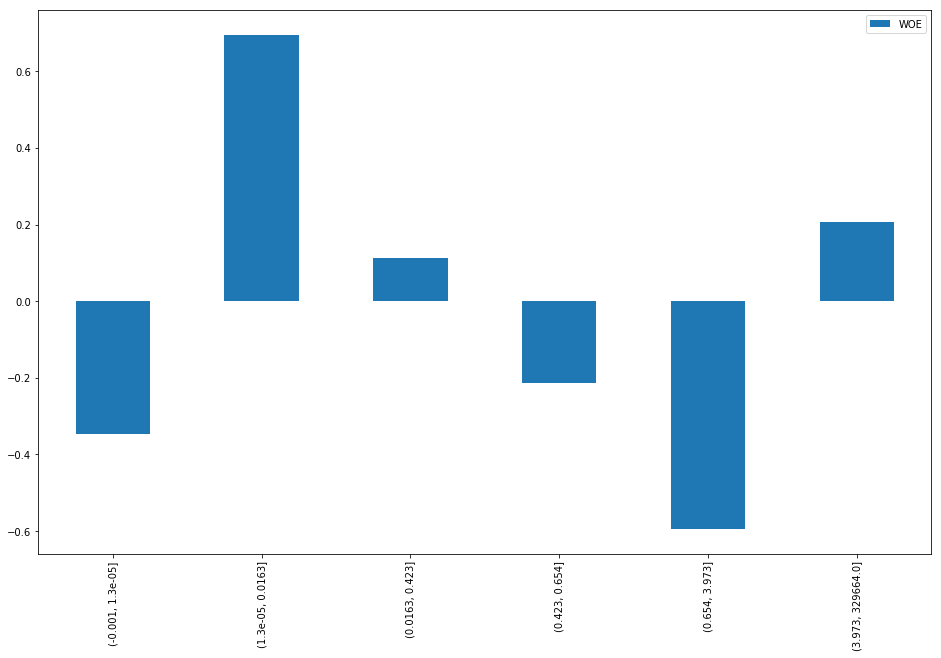

In [73]:
DebtRatio = smbin(train_data,y,"DebtRatio",10)

In [74]:
DebtRatio.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 1.3e-05]",3515,3191,324,0.023529,0.022894,0.032371,-0.3464,0.0033
1,"(1.3e-05, 0.0163]",8296,8009,287,0.055532,0.057461,0.028674,0.6951,0.0200
2,"(0.0163, 0.423]",71689,67363,4326,0.479875,0.483298,0.432211,0.1117,0.0057
3,"(0.423, 0.654]",21179,19451,1728,0.141769,0.139552,0.172645,-0.2128,0.0070
4,"(0.654, 3.973]",14648,12961,1687,0.098051,0.092989,0.168548,-0.5947,0.0449
5,"(3.973, 329664.0]",30064,28407,1657,0.201244,0.203807,0.165551,0.2079,0.0080
6,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0889


In [75]:
iv_all = iv_all.append(pd.Series({"DebtRatio":DebtRatio.IV}))

#### MonthlyIncome

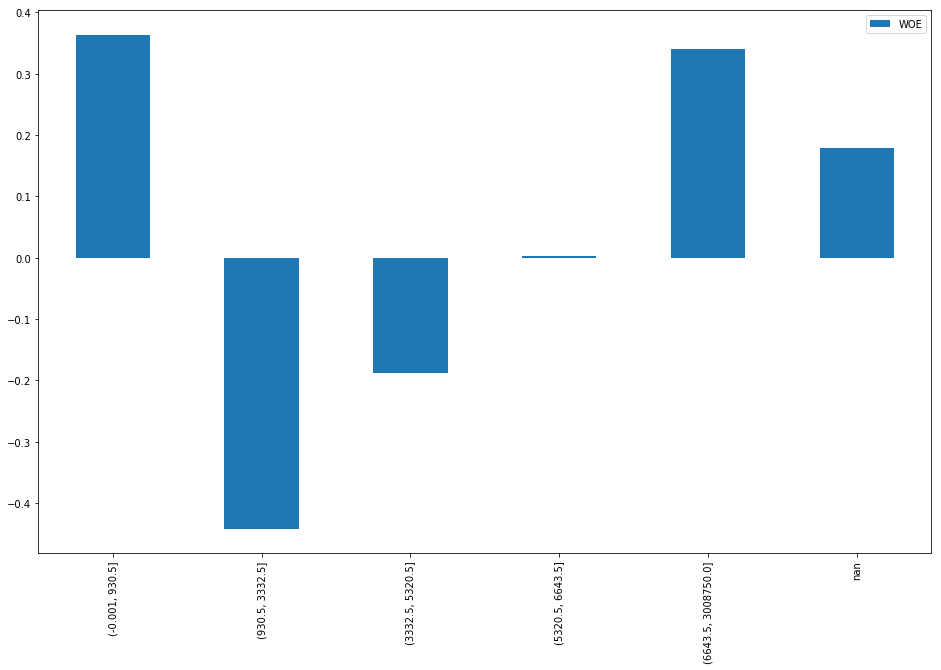

In [76]:
MonthlyIncome = smbin(train_data,y,"MonthlyIncome")

In [77]:
MonthlyIncome.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 930.5]",4229,4028,201,0.028308,0.028899,0.020082,0.3640,0.0032
1,"(930.5, 3332.5]",24574,22105,2469,0.164495,0.158593,0.246678,-0.4417,0.0389
2,"(3332.5, 5320.5]",30421,27994,2427,0.203633,0.200844,0.242482,-0.1884,0.0078
3,"(5320.5, 6643.5]",16128,15050,1078,0.107958,0.107977,0.107703,0.0025,0.0000
4,"(6643.5, 3008750.0]",44818,42638,2180,0.300005,0.305908,0.217804,0.3397,0.0299
5,nan,29221,27567,1654,0.195601,0.197780,0.165251,0.1797,0.0058
6,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0856


In [78]:
iv_all = iv_all.append(pd.Series({"MonthlyIncome":MonthlyIncome.IV}))

#### NumberOfOpenCreditLinesAndLoans

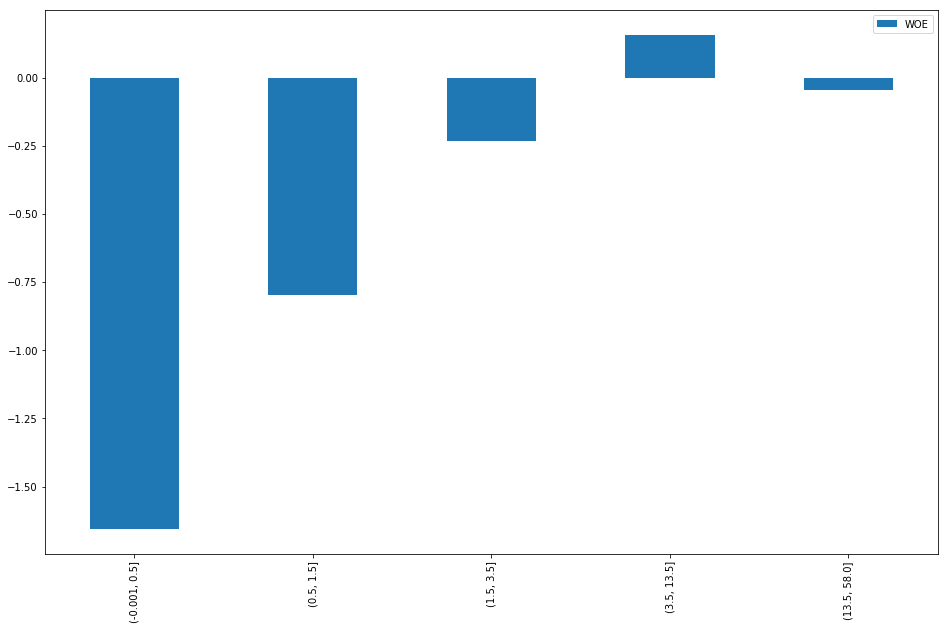

In [79]:
NOO = smbin(train_data,y,"NumberOfOpenCreditLinesAndLoans")

In [80]:
NOO.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",1712,1244,468,0.011460,0.008925,0.046758,-1.6561,0.0627
1,"(0.5, 1.5]",4251,3667,584,0.028456,0.026309,0.058347,-0.7965,0.0255
2,"(1.5, 3.5]",15550,14259,1291,0.104089,0.102302,0.128984,-0.2318,0.0062
3,"(3.5, 13.5]",105861,99732,6129,0.708617,0.715530,0.612349,0.1557,0.0161
4,"(13.5, 58.0]",22017,20480,1537,0.147378,0.146934,0.153562,-0.0441,0.0003
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.1108


In [81]:
iv_all = iv_all.append(pd.Series({"NumberOfOpenCreditLinesAndLoans":NOO.IV}))

#### NumberOfTimes90DaysLate

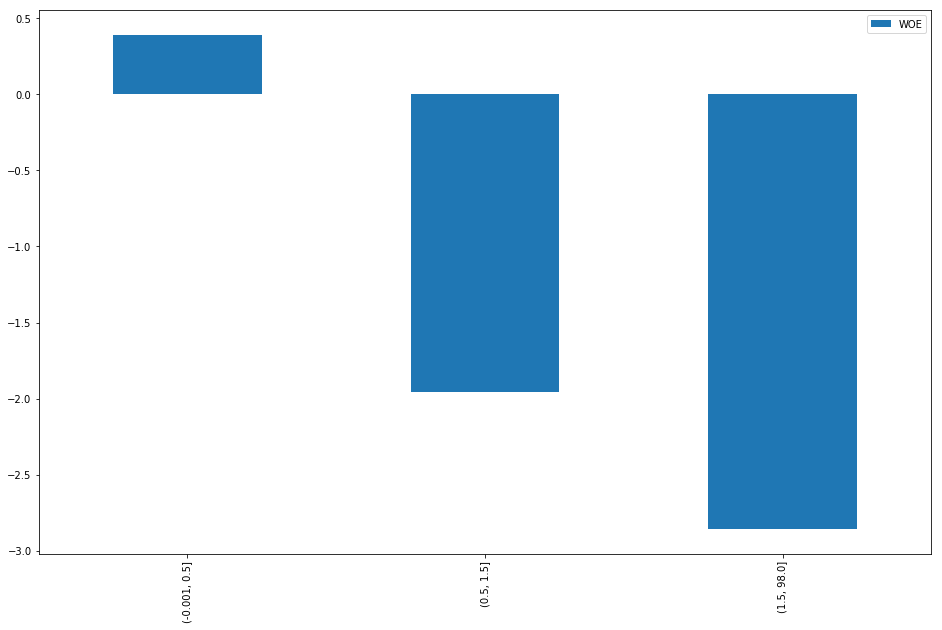

In [82]:
NO90 = smbin(train_data,y,"NumberOfTimes90DaysLate")

In [83]:
NO90.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",141108,134559,6549,0.944555,0.965397,0.654311,0.3890,0.1210
1,"(0.5, 1.5]",5232,3468,1764,0.035022,0.024881,0.176241,-1.9577,0.2963
2,"(1.5, 98.0]",3051,1355,1696,0.020423,0.009721,0.169447,-2.8582,0.4565
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.8738


In [84]:
iv_all = iv_all.append(pd.Series({"NumberOfTimes90DaysLate":NO90.IV}))

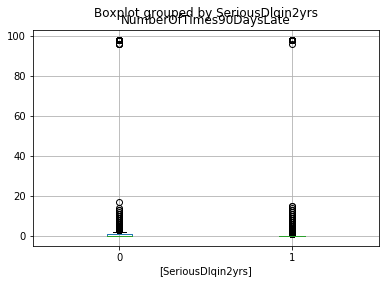

In [85]:
train_data.boxplot(column=["NumberOfTimes90DaysLate"],by=[y])

In [86]:
import scipy.stats as stats
stats.ttest_ind(train_data.loc[train_data.SeriousDlqin2yrs==1,"NumberOfTimes90DaysLate"],
                train_data.loc[train_data.SeriousDlqin2yrs==0,"NumberOfTimes90DaysLate"])

Ttest_indResult(statistic=-47.704547090568376, pvalue=0.0)

In [87]:
t0 = block(train_data["NumberOfTimes90DaysLate"])

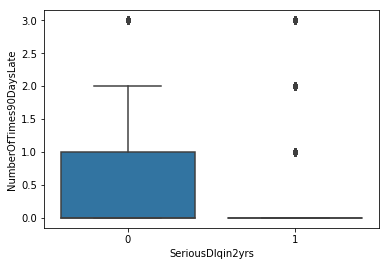

In [88]:
import seaborn as sns
sns.boxplot(x=train_data[y],y=t0)

#### NumberRealEstateLoansOrLines

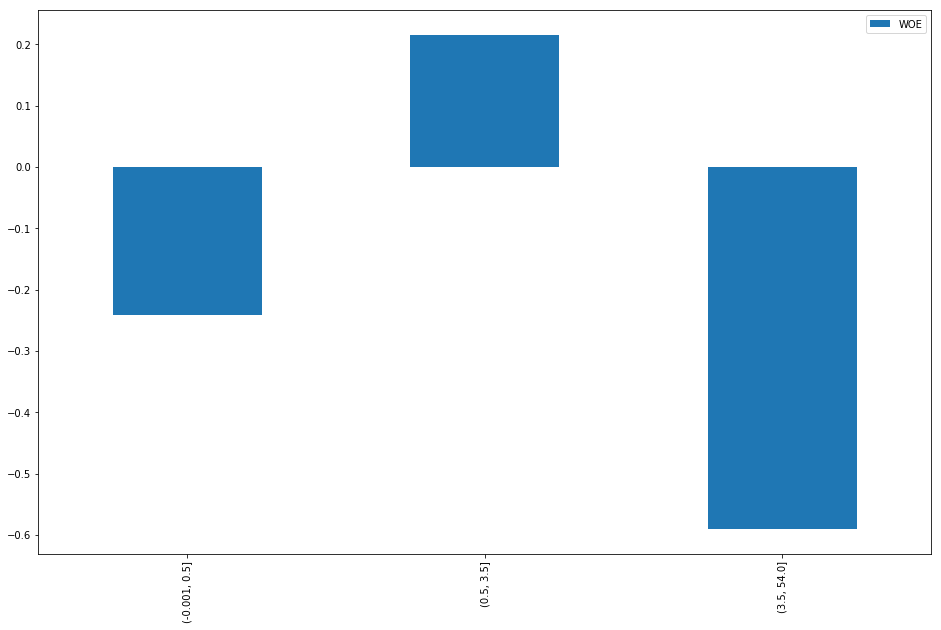

In [89]:
NRE = smbin(train_data,y,"NumberRealEstateLoansOrLines")

In [90]:
NRE.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",55579,50924,4655,0.372037,0.365356,0.465081,-0.2413,0.0241
1,"(0.5, 3.5]",90160,85225,4935,0.603517,0.611449,0.493056,0.2152,0.0255
2,"(3.5, 54.0]",3652,3233,419,0.024446,0.023195,0.041862,-0.5904,0.0110
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0606


In [91]:
iv_all = iv_all.append(pd.Series({"NumberRealEstateLoansOrLines":NRE.IV}))

#### NumberOfTime60_89DaysPastDueNotWorse

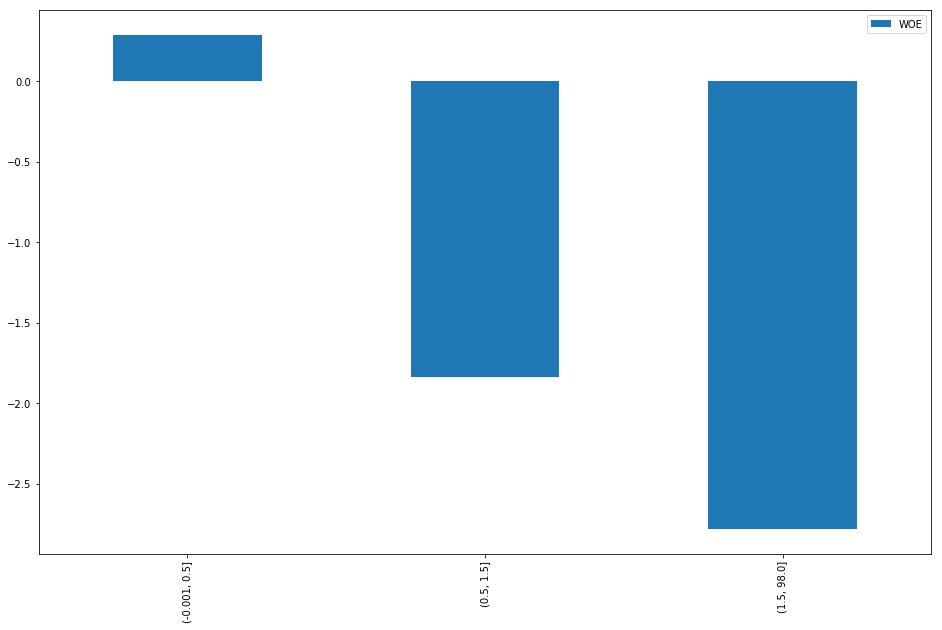

In [92]:
NO6089 = smbin(train_data,y,"NumberOfTime60_89DaysPastDueNotWorse")

In [93]:
NO6089.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",141831,134581,7250,0.949395,0.965555,0.724348,0.2874,0.0693
1,"(0.5, 1.5]",5731,3954,1777,0.038362,0.028368,0.177540,-1.8339,0.2736
2,"(1.5, 98.0]",1829,847,982,0.012243,0.006077,0.098112,-2.7816,0.2560
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.5989


In [94]:
iv_all = iv_all.append(pd.Series({"NumberOfTime60_89DaysPastDueNotWorse":NO6089.IV}))

#### NumberOfDependents

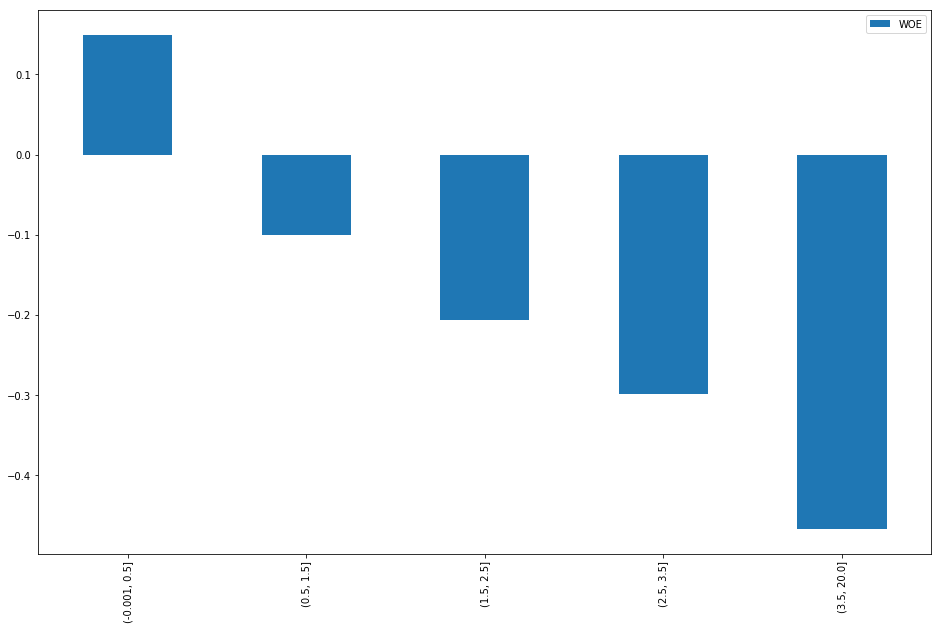

In [95]:
NOD = smbin(train_data,y,"NumberOfDependents")

In [96]:
NOD.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",90220,84963,5257,0.603919,0.609569,0.525227,0.1489,0.0126
1,"(0.5, 1.5]",26314,24379,1935,0.176142,0.174908,0.193326,-0.1001,0.0018
2,"(1.5, 2.5]",19521,17937,1584,0.130671,0.128690,0.158258,-0.2068,0.0061
3,"(2.5, 3.5]",9483,8646,837,0.063478,0.062031,0.083625,-0.2987,0.0065
4,"(3.5, 20.0]",3853,3457,396,0.025791,0.024802,0.039564,-0.4670,0.0069
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0339


In [97]:
iv_all = iv_all.append(pd.Series({"NumberOfDependents":NOD.IV}))

### 查看所有变量IV值

- IV值用于筛选变量,删除小于0.02的变量

In [98]:
iv_all.sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    1.1487
NumberOfTimes90DaysLate                 0.8738
NumberOfTime30_59DaysPastDueNotWorse    0.7576
NumberOfTime60_89DaysPastDueNotWorse    0.5989
age                                     0.2523
NumberOfOpenCreditLinesAndLoans         0.1108
DebtRatio                               0.0889
MonthlyIncome                           0.0856
NumberRealEstateLoansOrLines            0.0606
NumberOfDependents                      0.0339
dtype: float64

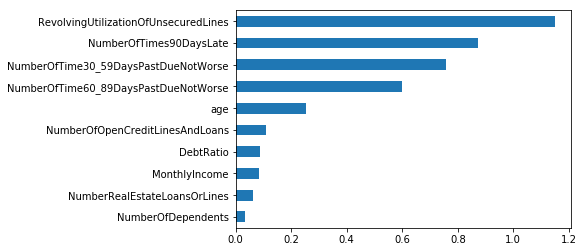

In [99]:
iv_all.sort_values().plot(kind="barh")

- 可见所有的IV值均大于0.02,故这里使用所有变量

### 生成WOE数据

- 之前smbin和smbin_cu得到的对象根据IV值筛选后,放在一个列表中

In [100]:
x_list = [RUO,age,NO3059,DebtRatio,MonthlyIncome,NOO,NO90,NRE,NO6089,NOD]

- 使用smgen函数根据得到的列表生成新数据

In [101]:
data_woe = smgen(train_data,x_list)

In [102]:
data_woe.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,...,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
1,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,-0.8258,-0.1385,-1.6142,-0.5947,0.3397,0.1557,0.3890,-0.5904,0.2874,-0.2068
2,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,-1.2175,-0.3249,0.5408,0.1117,-0.4417,0.1557,0.3890,-0.2413,0.2874,-0.1001
3,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,-0.3778,-0.3249,-0.9011,0.1117,-0.4417,-0.2318,-1.9577,-0.2413,0.2874,0.1489
4,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.7032,-0.5507,0.5408,0.1117,-0.4417,0.1557,0.3890,-0.2413,0.2874,0.1489
5,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,-1.2175,-0.1385,-0.9011,0.1117,0.3397,0.1557,0.3890,0.2152,0.2874,0.1489


- 抽取WOE列作为预测数据X
- 加常数项列
- 抽取响应列作为Y

In [103]:
X = data_woe.iloc[:,-len(x_list):]
X = sm.add_constant(X)
Y = data_woe[y]

C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- 分训练集和测试集

In [104]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1221)

### 建模

- 建立逻辑回归模型,拟合数据,查看回归结果

In [105]:
glmodel = sm.GLM(Y_train,X_train,family=sm.families.Binomial()).fit()

In [106]:
glmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               104573
Model:                            GLM   Df Residuals:                   104562
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19183.
Date:                Tue, 23 Apr 2019   Deviance:                       38367.
Time:                        22:51:51   Pearson chi2:                 9.05e+04
No. Iterations:                     7   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        2.5902      0.015    172.105      0.000       2.561       2.620
RevolvingUtilizationOfUnsecuredLines_woe     0.5947      0.014     41.272      0.000       0.566       0.623
age_woe                                      0.4297      0.032     13.510      0.000       0.367       0.492
NumberOfTime30_59DaysPastDueNotWorse_woe     0.5073      0.016     32.411      0.000       0.477       0.538
DebtRatio_woe                                0.7051      0.050     14.076      0.000       0.607       0.803
MonthlyIncome_woe                            0.1821      0.049      3.690      0.000       0.085       0.279
NumberOfOpenCreditLinesAndLoans_woe          0.0059      0.041      0.142      0.887      -0.075       0.087
NumberOfTimes90DaysLate_woe                  0.5302      0.014     38.254      0.000       0.503       0.557
NumberRealEstateLoansOrLines_woe             0.5383      0.062      8.642      0.000       0.416       0.660
NumberOfTime60_89DaysPastDueNotWorse_woe     0.3749      0.017     22.125      0.000       0.342       0.408
NumberOfDependents_woe                       0.2624      0.077      3.388      0.001       0.111       0.414
============================================================================================================
"""

#### 查看共线性

- 计算每个预测变量的vif值,查看是否存在共线性

In [107]:
vif = [variance_inflation_factor(X_train.iloc[:,1:].values,i
                                 ) for i in range(X_train.shape[1]-1)]
print(pd.Series(dict(zip(X_train.columns[1:],vif))))

RevolvingUtilizationOfUnsecuredLines_woe    1.526123
age_woe                                     1.206090
NumberOfTime30_59DaysPastDueNotWorse_woe    1.355447
DebtRatio_woe                               1.182366
MonthlyIncome_woe                           1.122016
NumberOfOpenCreditLinesAndLoans_woe         1.182690
NumberOfTimes90DaysLate_woe                 1.421802
NumberRealEstateLoansOrLines_woe            1.192780
NumberOfTime60_89DaysPastDueNotWorse_woe    1.339235
NumberOfDependents_woe                      1.129460
dtype: float64


- 可见不存在共线性

### 生成评分卡

- 根据逻辑回归模型和之前筛选得到的列表,给定参数,生成评分卡
- 调整参数,使得评分卡分数范围满足需求

In [108]:
scorecard = smscale(glmodel,x_list,pdo=43,score=1150,odds=10)
scorecard.minmaxscore

[301, 842]

- 查看最终的评分卡

In [109]:
scorecard.ScoreCard

,Characteristic,Attribute,Points
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.132]",118
1,RevolvingUtilizationOfUnsecuredLines,"(0.132, 0.301]",94
2,RevolvingUtilizationOfUnsecuredLines,"(0.301, 0.495]",74
3,RevolvingUtilizationOfUnsecuredLines,"(0.495, 0.698]",55
4,RevolvingUtilizationOfUnsecuredLines,"(0.698, 0.863]",38
5,RevolvingUtilizationOfUnsecuredLines,"(0.863, 1.003]",24
6,RevolvingUtilizationOfUnsecuredLines,"(1.003, 50708.0]",-9
0,age,"(-0.001, 36.5]",54
1,age,"(36.5, 43.5]",60
2,age,"(43.5, 55.5]",65


- 评分卡写出到csv文件

In [110]:
scorecard.ScoreCard.to_csv("ScoreCard.csv",index=False)

### 模型评估

- 根据之前的分卡对象得到测试集分数

In [111]:
testscore = smscoregen(scorecard,X_test)

In [112]:
testscore.head()

,const,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,...,age_Score,NumberOfTime30_59DaysPastDueNotWorse_Score,DebtRatio_Score,MonthlyIncome_Score,NumberOfOpenCreditLinesAndLoans_Score,NumberOfTimes90DaysLate_Score,NumberRealEstateLoansOrLines_Score,NumberOfTime60_89DaysPastDueNotWorse_Score,NumberOfDependents_Score,Score
0,1.0,1.3365,-0.1385,-0.9011,0.1117,0.3397,0.1557,0.3890,0.2152,0.2874,...,65,40,73,72,69,81,76,75,64,733
1,1.0,1.3365,-0.3249,-0.9011,0.1117,0.3397,0.1557,-1.9577,0.2152,-1.8339,...,60,40,73,72,69,4,76,26,67,605
2,1.0,1.3365,-0.1385,0.5408,0.6951,0.3397,0.1557,0.3890,-0.2413,0.2874,...,65,86,99,72,69,81,60,75,64,789
3,1.0,-0.8258,-0.3249,0.5408,-0.5947,0.3397,0.1557,0.3890,0.2152,0.2874,...,60,86,43,72,69,81,76,75,65,665
4,1.0,1.3365,0.9583,0.5408,0.1117,-0.1884,-0.2318,0.3890,0.2152,0.2874,...,94,86,73,66,68,81,76,75,71,808


- 通过测试集中真实的y,和预测的分数,绘制ks曲线
- 得到对应的最优阈值以及相关度量

The optimal cutoff(for ks) is 690.0
The maximum value of ks is: 0.5631
Score      690.000000
TP       33221.000000
FP         683.000000
FN        8635.000000
TN        2279.000000
rpp          0.756482
tpr          0.793697
fpr          0.230587
ppv          0.979855
acc          0.792092
f            0.877006
ks           0.563110
lift         1.049196
Name: 33903, dtype: float64


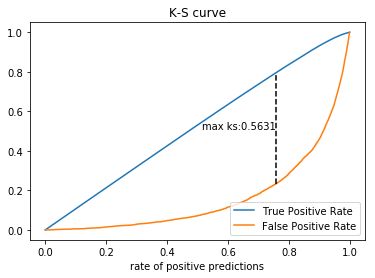

In [122]:
evaluate1 = evaluate01(Y_test,testscore["Score"],index="ks",plot="ks")

- 绘制ROC曲线

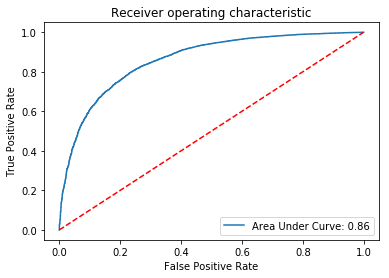

In [123]:
evaluate2 = evaluate01(Y_test,testscore["Score"],plot="roc",report=False)

### 新数据预测

- 读取待预测的新数据

In [115]:
os.chdir("D:/data/python")
test_data = pd.read_csv("cs-test.csv",index_col=0)

- 对数据进行与训练数据相同的清洗,即使用之前定义的清洗函数

In [116]:
test0 = datacleaning(test_data)

- 由之前得到的分箱对象生成包含woe列的数据

In [117]:
test_woe = smgennew(test0,x_list)
test_woe.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,...,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,...,-1.2175,-0.3249,0.5408,0.1117,0.0025,0.1557,0.389,-0.2413,0.2874,0.1489
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,...,0.1515,0.3025,0.5408,-0.2128,0.3397,-0.0441,0.389,-0.5904,0.2874,-0.2068
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,...,1.3365,0.3025,0.5408,-0.5947,-0.1884,0.1557,0.389,0.2152,0.2874,-0.2068
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,...,0.7032,-0.3249,-0.9011,-0.5947,-0.4417,0.1557,0.389,0.2152,0.2874,0.1489
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,...,-1.2175,-0.5507,0.5408,0.1117,-0.1884,0.1557,0.389,-0.2413,0.2874,-0.1001


- 抽取WOE数据生成预测用数据
- 要加常数项列

In [118]:
T = test_woe.iloc[:,-len(x_list):]
T = sm.add_constant(T)

C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- 预测每一行数据是好客户的概率

In [119]:
y_pred = glmodel.predict(T)

- 预测每行数据的分数,生成总分数和每个特征的分数

In [120]:
Tscore = smscoregen(scorecard,T)

- 根据分数和训练得到的阈值判断客户的好坏,好客户是1,坏客户是0

In [124]:
test0[y] = (Tscore.Score > evaluate1.cutoff)*1
test0.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
1,1.0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,1.0,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,0.0,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,0.0,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,1.0,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
